In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal

# Loading LDC1-3 Verification Binary dataset (128Mb)

In [2]:
#!wget https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC1-3_VGB_v2.hdf5

### Parse hdf5 file

In [3]:
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

fid = h5py.File('LDC1-3_VGB_v2.hdf5')
fid.visititems(print_attrs)

H5LISA
    H5LISA/Author
    H5LISA/GWSources
        H5LISA/GWSources/GalBinaries
            H5LISA/GWSources/GalBinaries/Amplitude
                Units: strain
            H5LISA/GWSources/GalBinaries/Cadence
                Units: Seconds
            H5LISA/GWSources/GalBinaries/EclipticLatitude
                Units: Radian
            H5LISA/GWSources/GalBinaries/EclipticLongitude
                Units: Radian
            H5LISA/GWSources/GalBinaries/Frequency
                Units: Hz
            H5LISA/GWSources/GalBinaries/FrequencyDerivative
                Units: Hz^2
            H5LISA/GWSources/GalBinaries/Inclination
                Units: Radian
            H5LISA/GWSources/GalBinaries/InitialPhase
                Units: Radian
            H5LISA/GWSources/GalBinaries/ObservationDuration
                Units: Seconds
            H5LISA/GWSources/GalBinaries/Polarization
                Units: Radian
    H5LISA/History
        H5LISA/History/0000
        H5LISA/History/

### Get input source parameters

In [4]:
fid = h5py.File("LDC1-3_VGB_v2.hdf5")

# get the source parameters
names = np.array(fid['H5LISA/GWSources/GalBinaries'])
params = [fid['H5LISA/GWSources/GalBinaries'][k] for k in names]
params = [np.array(p) for p in params if p.shape]
cat = np.rec.fromarrays(params, names=list(names))
pd.DataFrame(cat)

,Amplitude,Cadence,EclipticLatitude,EclipticLongitude,Frequency,FrequencyDerivative,Inclination,InitialPhase
0,1.073450e-22,0.312414,-2.75291,0.001360,8.945813e-19,0.523599,3.058156,3.562166
1,1.363680e-22,-0.529009,-2.51031,0.001253,9.159587e-19,0.244346,2.644144,2.229426
2,1.762760e-22,0.086568,-2.18009,0.001813,2.049740e-18,0.523599,2.974591,3.619093
3,7.346080e-23,0.490263,2.28603,0.001667,2.189059e-18,1.221730,3.221988,3.044662
4,1.509330e-22,0.653451,2.97387,0.001944,6.489726e-18,0.750492,3.006892,2.117236
5,5.359060e-23,-0.354825,0.42970,0.003221,1.745867e-17,1.616935,2.840901,2.532922
6,3.295700e-23,0.816989,-1.13534,0.003512,2.785700e-17,1.506329,3.185514,2.861225
7,7.395470e-23,0.490263,2.28603,0.001684,2.271208e-18,1.679481,3.579801,3.055940
8,6.378230e-23,-0.082205,2.10225,0.006220,7.485286e-16,0.645772,3.171656,2.916178
9,1.669970e-22,0.101404,1.76872,0.002613,2.905628e-17,1.516690,3.121841,3.803728


In [5]:
# get units
units = [(k, fid['H5LISA/GWSources/GalBinaries'][k].attrs.get('Units')) for k in names]
units = dict(units)
units

{'Amplitude': 'strain',
 'Cadence': 'Seconds',
 'EclipticLatitude': 'Radian',
 'EclipticLongitude': 'Radian',
 'Frequency': 'Hz',
 'FrequencyDerivative': 'Hz^2',
 'Inclination': 'Radian',
 'InitialPhase': 'Radian',
 'ObservationDuration': 'Seconds',
 'Polarization': 'Radian'}

### Get TDI witn instrumental noise

In [6]:
# get TDI 
tdi = np.array(fid["H5LISA/PreProcess/TDIdata"])
tdi = np.rec.fromarrays(list(tdi.T), names=["t", "X", "Y", "Z"])
pd.DataFrame(tdi)

,t,X,Y,Z
0,15.0,-3.974823e-20,1.810066e-21,-5.476181e-20
1,30.0,9.805234e-21,5.277763e-20,1.191873e-20
2,45.0,1.623164e-20,-7.591719e-20,2.488446e-20
3,60.0,-3.281446e-20,7.336391e-20,-5.049898e-20
4,75.0,3.672010e-20,-5.162748e-20,6.101334e-20
...,...,...,...,...
4194299,62914500.0,-1.457889e-20,5.843312e-21,-4.875725e-21
4194300,62914515.0,-1.717444e-21,7.281903e-21,8.364995e-21
4194301,62914530.0,-1.408427e-20,9.695762e-21,-2.874223e-22
4194302,62914545.0,-1.509764e-20,9.199856e-21,-9.034301e-22


Text(0.5, 0, 'Freq [Hz]')

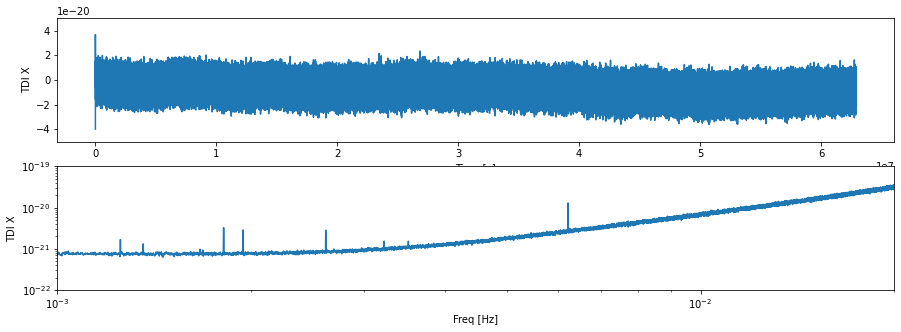

In [7]:
dt = tdi['t'][1]-tdi['t'][0]
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(tdi['t'], tdi["X"])
plt.axis([None, None, -0.5e-19, 0.5e-19])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.subplot(212)
f, psdX =  scipy.signal.welch(tdi["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX))
plt.axis([1e-3, 2e-2, 1e-22, 1e-19])
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")

### Loading noise free data

In [8]:
#!wget https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC1-3_VGB_v2_FD_noiseless.hdf5

In [9]:
fid = h5py.File('LDC1-3_VGB_v2_FD_noiseless.hdf5')
tdi_nf = np.array(fid["H5LISA/PreProcess/TDIdata"])
tdi_nf = np.rec.fromarrays(list(tdi_nf.T), names=["t", "X", "Y", "Z"])

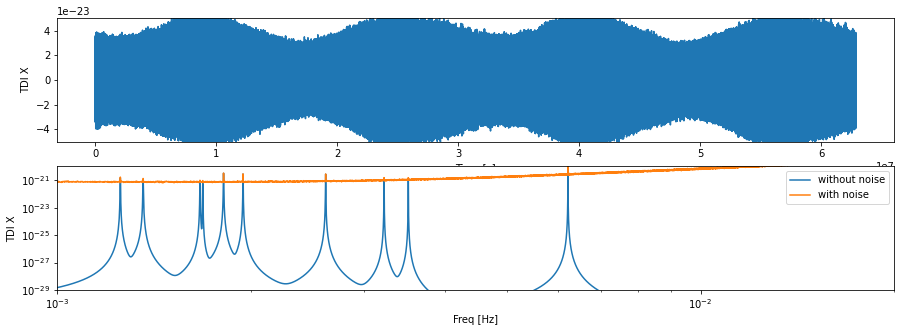

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(tdi['t'], tdi_nf["X"])
plt.axis([None, None, -0.5e-22, 0.5e-22])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.subplot(212)
f2, psdX_nf =  scipy.signal.welch(tdi_nf["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f2, np.sqrt(psdX_nf), label='without noise')
plt.loglog(f, np.sqrt(psdX), label='with noise')
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")
plt.axis([1e-3, 2e-2, 1e-29, 1e-20])
plt.legend()

# Loading Massive Black Hole Binary dataset

In [11]:
#!wget https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC1-1_MBHB_v2_TD_9gc2s16.hdf5

### Get the source parameter

In [12]:
fid = h5py.File("LDC1-1_MBHB_v2_FD.hdf5")

# get the source parameters
names = np.array(fid['H5LISA/GWSources/MBHB-0'])
params = [fid['H5LISA/GWSources/MBHB-0'].get(k)[()] for k in names]
params = dict(zip(names, params))
hphc = np.rec.fromarrays(list(params["hphcData"].T), names=["t", "hp", "hc"])  ; params.pop("hphcData")
print(params)

{'Approximant': b'IMRPhenomD', 'AzimuthalAngleOfSpin1': 1.409821176980296, 'AzimuthalAngleOfSpin2': 4.386687957606034, 'Cadence': 10.0, 'CoalescenceTime': 24960000.0, 'Distance': 56.00578366287752, 'EclipticLatitude': 0.29269632679489654, 'EclipticLongitude': 3.5091, 'InitialAzimuthalAngleL': 1.65330190000514, 'InitialPolarAngleL': 1.8554, 'Mass1': 2599137.035, 'Mass2': 1242860.685, 'ObservationDuration': 41943040.0, 'PhaseAtCoalescence': 6.247897265570264, 'PolarAngleOfSpin1': 0.0, 'PolarAngleOfSpin2': 0.0, 'Redshift': 5.7309, 'Spin1': 0.7534821857057837, 'Spin2': 0.6215875279643664}


### Plot h+, hx

Text(0.5, 0, 'Time [s]')

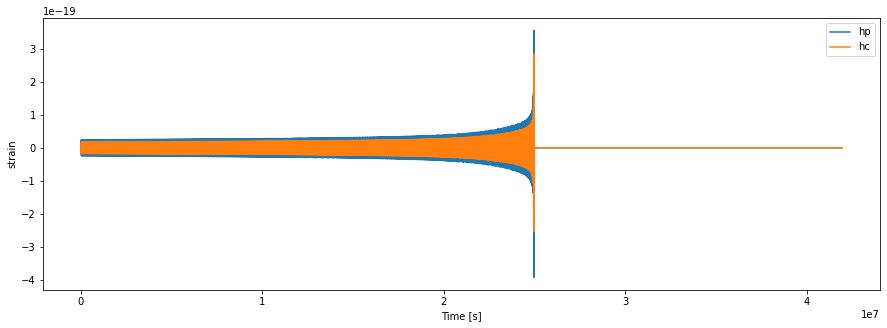

In [13]:
plt.figure(figsize=(15,5))
plt.plot(hphc['t'], hphc['hp'], label='hp')
plt.plot(hphc['t'], hphc['hc'], label='hc')
plt.legend()
plt.ylabel("strain")
plt.xlabel("Time [s]")

### Get noisy TDI

Text(0.5, 0, 'Freq [Hz]')

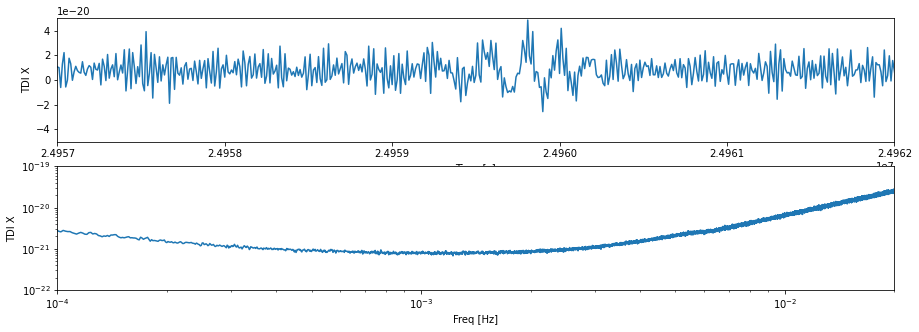

In [14]:
# get TDI 
tdi = np.array(fid["H5LISA/PreProcess/TDIdata"])
tdi = np.rec.fromarrays(list(tdi.T), names=["t", "X", "Y", "Z"])
dt = tdi['t'][1]-tdi['t'][0]
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(tdi['t'], tdi["X"])
plt.axis([2.4957e7, 2.4962e7, -0.5e-19, 0.5e-19])
plt.ylabel("TDI X")
plt.xlabel("Time [s]")
plt.subplot(212)
f, psdX =  scipy.signal.welch(tdi["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX))
plt.axis([1e-4, 2e-2, 1e-22, 1e-19])
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")

# Some tips to deal with indexed data

In the LDC toolbox, we use the [xarray](http://xarray.pydata.org/en/stable/) python package to handle time and frequency series. 

In [15]:
import xarray as xr
hp = xr.DataArray(hphc['hp'], dims=('t'), coords={'t':hphc["t"]})
hc = xr.DataArray(hphc['hc'], dims=('t'), coords={'t':hphc["t"]})

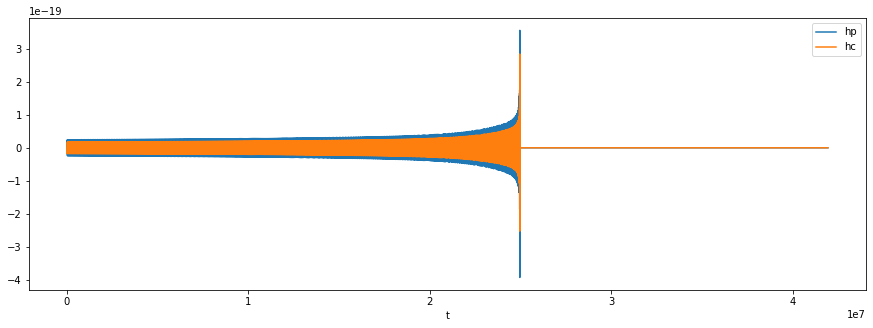

In [16]:
plt.figure(figsize=(15,5))
hp.plot(label='hp')
hc.plot(label='hc')
plt.legend()

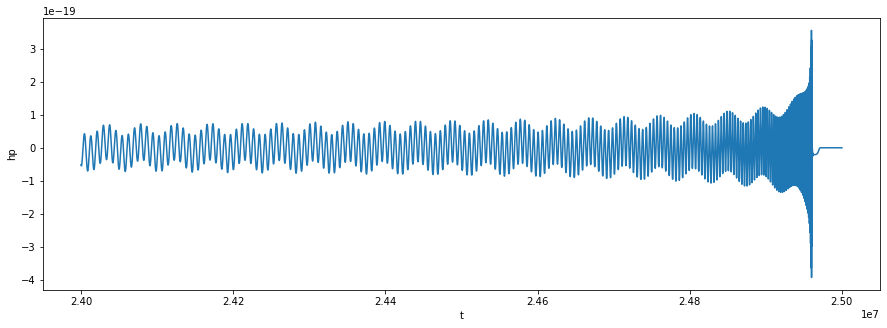

In [17]:
# data selection along time coordinate
ds = xr.Dataset({'hp':hp, 'hc':hc})
around_merger = ds.sel(t=slice(24000000, 25000000))
plt.figure(figsize=(15,5))
around_merger['hp'].plot()

# Fourier transform